In [1]:
# Load denoise model and imputation model


In [2]:
denoise_gen_path = '/home/x_l30/Diffusion/Bio_signal_Diffusion/experiments/mitbih_denoise_230323_153533/checkpoint/I270000_E120_gen.pth'

In [3]:
imputation_gen_path = '/home/x_l30/Diffusion/Bio_signal_Diffusion/experiments/mitbih_imputation_230323_183906/checkpoint/I130000_E58_gen.pth'

In [4]:
import model.modules.UNet1D as unet1d
import model.modules.diffusion1D as diffusion1D
from torch.utils.data import Dataset
import torch
import pandas as pd
import numpy as np

In [5]:
denoise_model = unet1d.UNet(
    in_channel=2,
    out_channel=1,
    norm_groups=32,
    inner_channel=64,
    channel_mults=[1, 2, 4, 8, 8],
    attn_res=[16],
    res_blocks=2,
    dropout=0.2,
    seq_length=128
)
denoise_netG = diffusion1D.GaussianDiffusion(
    denoise_model,
    seq_length=128,
    channels=1,
    loss_type='l1',    # L1 or L2
    conditional=True,
    schedule_opt={
                "schedule": "linear",
                "n_timestep": 2000,
                "linear_start": 1e-6,
                "linear_end": 1e-2
            }
)

In [6]:
denoise_netG.load_state_dict(torch.load(denoise_gen_path))

<All keys matched successfully>

In [7]:
imputation_model = unet1d.UNet(
    in_channel=2,
    out_channel=1,
    norm_groups=32,
    inner_channel=64,
    channel_mults=[1, 2, 4, 8, 8],
    attn_res=[16],
    res_blocks=2,
    dropout=0.2,
    seq_length=128
)
imputation_netG = diffusion1D.GaussianDiffusion(
    imputation_model,
    seq_length=128,
    channels=1,
    loss_type='l1',    # L1 or L2
    conditional=True,
    schedule_opt={
                "schedule": "linear",
                "n_timestep": 2000,
                "linear_start": 1e-6,
                "linear_end": 1e-2
            }
)

In [8]:
imputation_netG.load_state_dict(torch.load(imputation_gen_path))

<All keys matched successfully>

In [9]:
def test(netG, data_opt, continous=False):
    with torch.no_grad():
        SR = netG.super_resolution(
            data_opt['SR'], continous)
    return SR 

In [10]:
from data.MITBIH import mitbih_denosing
from data.MITBIH import mitbih_imputation

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [11]:
mitbih_noisy = mitbih_denosing(class_id = 0, train_mode=False)
mitbih_noise_loader = torch.utils.data.DataLoader(mitbih_noisy, batch_size=1, shuffle=True, num_workers=1)

mitbih_masked = mitbih_imputation(class_id = 0, train_mode=False)
mitbih_imputation_loader = torch.utils.data.DataLoader(mitbih_masked, batch_size=1, shuffle=True, num_workers=1)

Data shape of Non-Ectopic Beats instances = (18118, 1, 128)


In [12]:
denoise_original_data = []
denoise_conditonal_data = []
denoise_synthetic_data = []
denoise_netG.eval()

with torch.no_grad():
    for i, data_opt in enumerate(mitbih_noise_loader):
        data_opt['HR'] = data_opt['HR'].to(torch.float)
        data_opt['SR'] = data_opt['SR'].to(torch.float)
        SR = denoise_netG.super_resolution(data_opt['SR'])
        denoise_original_data.append(data_opt['HR'])
        denoise_conditonal_data.append(data_opt['SR'])
        denoise_synthetic_data.append(SR)
        if i > 10:
            break

sampling loop time step: 100%|██████████| 2000/2000 [00:34<00:00, 58.24it/s]


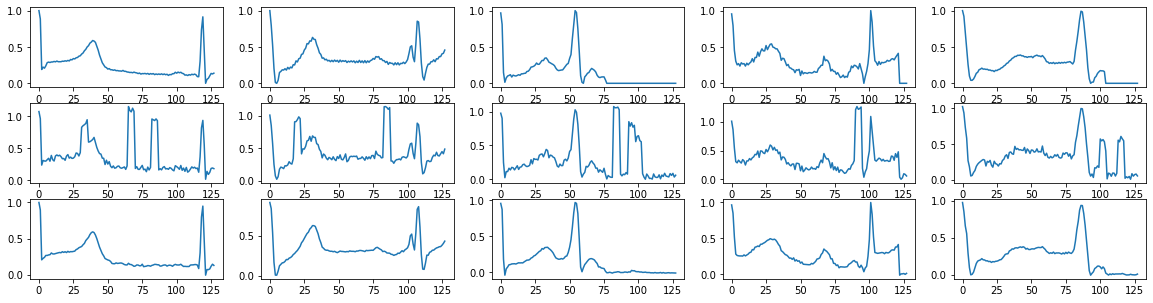

In [13]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 5, figsize=(20,5))
for i in range(5):
    axs[0, i].plot(denoise_original_data[i][0][0][:])
    axs[1, i].plot(denoise_conditonal_data[i][0][0][:])
    axs[2, i].plot(denoise_synthetic_data[i][0][:])
plt.savefig('./noise_reduction.pdf', format="pdf")

In [14]:
imputation_original_data = []
imputation_conditonal_data = []
imputation_synthetic_data = []
imputation_netG.eval()

with torch.no_grad():
    for i, data_opt in enumerate(mitbih_imputation_loader):
        data_opt['HR'] = data_opt['HR'].to(torch.float)
        data_opt['SR'] = data_opt['SR'].to(torch.float)
        SR = imputation_netG.super_resolution(data_opt['SR'])
        imputation_original_data.append(data_opt['HR'])
        imputation_conditonal_data.append(data_opt['SR'])
        imputation_synthetic_data.append(SR)
        if i > 10:
            break

sampling loop time step: 100%|██████████| 2000/2000 [00:39<00:00, 50.93it/s]


In [57]:
data_opt['SR'].shape

torch.Size([1, 1, 128])

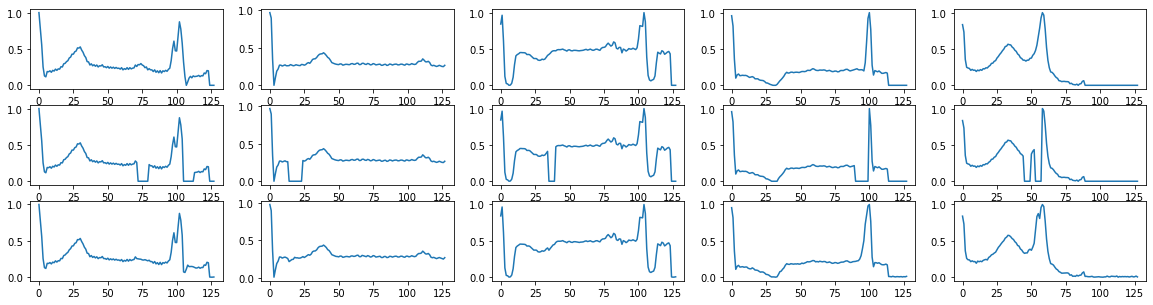

In [15]:
fig, axs = plt.subplots(3, 5, figsize=(20,5))
for i in range(5):
    axs[0, i].plot(imputation_original_data[i][0][0][:])
    axs[1, i].plot(imputation_conditonal_data[i][0][0][:])
    axs[2, i].plot(imputation_synthetic_data[i][0][:])
plt.savefig('./signal_imputation.pdf', format="pdf")

In [37]:
single_sig = denoise_original_data[4]

In [38]:
single_sig.shape

torch.Size([1, 1, 128])

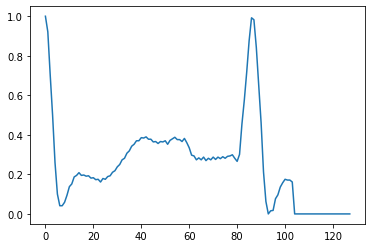

In [39]:
plt.plot(single_sig[0][0][:])

In [96]:
signal_repeated = np.tile(single_sig, (10, 1, 1))

In [97]:
signal_repeated.shape

(10, 1, 128)

In [ ]:
noisy_single_signals = np.title
signal_repeated = np.tile(signal, (num_repeats, 1, 1))

In [43]:
# Set the desired noise levels
num_signals, signal_length = 10, 128
clean_ecg_signals = np.random.rand(num_signals, signal_length) 

thermal_noise_level = 0.1
electrode_noise_level = 0.2
motion_artifact_level = 0.3
emg_noise_level = 0.4

# Generate and add thermal noise (white noise)
thermal_noise = np.random.normal(loc=0, scale=thermal_noise_level, size=(num_signals, signal_length))

# Generate and add electrode contact noise (low-frequency drift)
t = np.linspace(0, signal_length, signal_length)
electrode_noise = electrode_noise_level * np.sin(2 * np.pi * 0.05 * t)
electrode_noise = np.tile(electrode_noise, (num_signals, 1))

# Generate and add motion artifacts (random spikes)
num_spikes = 3
spike_positions = np.random.randint(0, signal_length, (num_signals, num_spikes))
motion_artifacts = np.zeros_like(clean_ecg_signals)
for i in range(num_signals):
    for spike_pos in spike_positions[i]:
        motion_artifacts[i, spike_pos:spike_pos + 10] = motion_artifact_level

# Generate and add EMG noise (simulated as high-frequency noise)
emg_noise = np.random.normal(loc=0, scale=emg_noise_level, size=(num_signals, signal_length))
emg_noise = np.diff(emg_noise, n=2, axis=1)  # Differentiate twice to simulate high-frequency noise
emg_noise = np.pad(emg_noise, ((0, 0), (2, 0)), mode='constant')  # Pad to restore the original shape

In [101]:
thermal_noise_level = 0.1
thermal_noise = np.random.rand(10, 1, 128) * thermal_noise_level

num_spikes_per_signal = np.random.randint(1, 5, 10)  # Randomly select the number of spikes for each signal
motion_artifacts = np.zeros_like(signal_repeated)
for i in range(10):
    spike_positions = np.random.randint(0, 128, num_spikes_per_signal[i])
    spike_amplitudes = np.random.uniform(0.3, 1, num_spikes_per_signal[i])
    for spike_pos, spike_amp in zip(spike_positions, spike_amplitudes):
        motion_artifacts[i, 0, spike_pos:spike_pos + 5] = spike_amp

In [102]:
noisy_ecg_signals = signal_repeated + thermal_noise + motion_artifacts

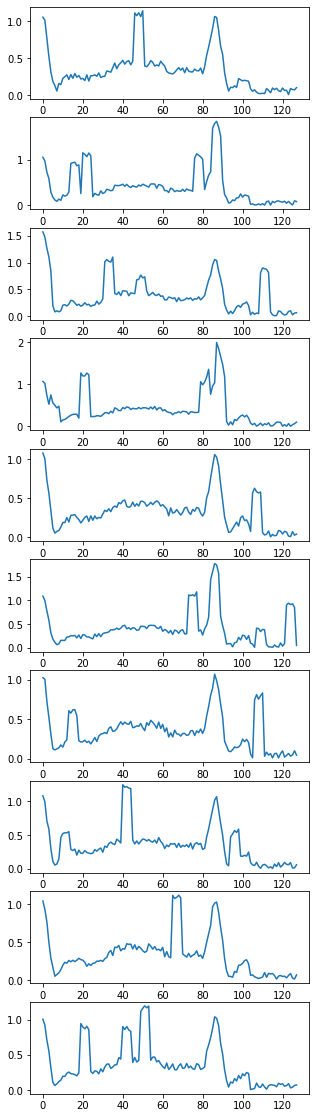

In [103]:
fig, axs = plt.subplots(10, 1, figsize=(5,20))
for i in range(10):
    axs[i].plot(noisy_ecg_signals[i][0][:])

In [104]:
noisy_ecg_signals = noisy_ecg_signals.reshape(noisy_ecg_signals.shape[0], noisy_ecg_signals.shape[1], 1, noisy_ecg_signals.shape[2])
signal_repeated = signal_repeated.reshape(signal_repeated.shape[0], signal_repeated.shape[1], 1, signal_repeated.shape[2])

In [105]:
import torch
denoise_original_data = []
denoise_conditonal_data = []
denoise_synthetic_data = []
denoise_netG.eval()

with torch.no_grad():
    for i in range(10):
        data_HR = torch.tensor(signal_repeated[i]).to(torch.float)
        data_SR = torch.tensor(noisy_ecg_signals[i]).to(torch.float)
        SR = denoise_netG.super_resolution(data_SR)
        denoise_original_data.append(data_HR)
        denoise_conditonal_data.append(data_SR)
        denoise_synthetic_data.append(SR)

sampling loop time step: 100%|██████████| 2000/2000 [00:39<00:00, 51.16it/s]


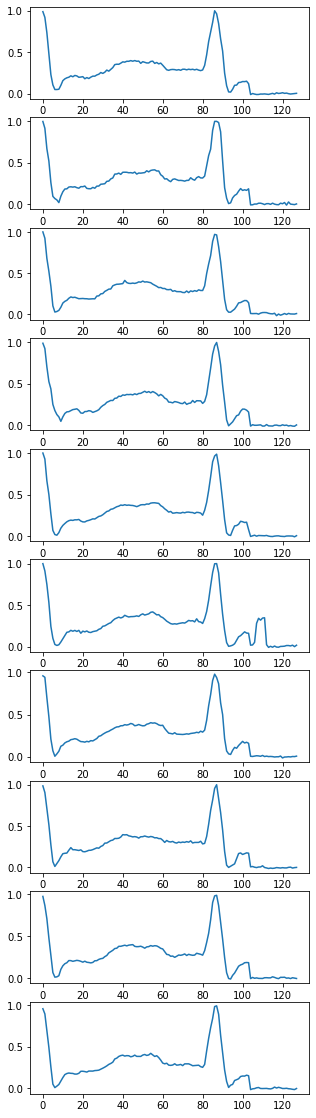

In [106]:
fig, axs = plt.subplots(10, 1, figsize=(5,20))
for i in range(10):
    axs[i].plot(denoise_synthetic_data[i][0][:])

In [63]:
len(denoise_synthetic_data)

10

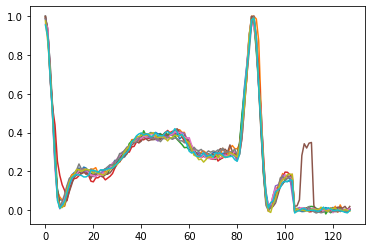

In [109]:
fig, ax = plt.subplots()
for i in range(10):
    ax.plot(denoise_synthetic_data[i][0][:])
plt.savefig('./synthetic_single_signals3.pdf', format = 'pdf')

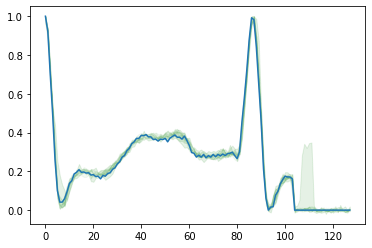

In [110]:
fig, ax = plt.subplots()
for i in range(9):
    ax.fill_between(range(128), denoise_synthetic_data[i][0][:], denoise_synthetic_data[i+1][0][:], alpha=0.05, color='green')
plt.plot(single_sig[0][0][:])
plt.savefig('./synthetic_single_signals4.pdf', format = 'pdf')

In [116]:
SR_HR_gen_path = '/home/x_l30/Diffusion/Bio_signal_Diffusion/experiments/simulated_SR_HR_230512_165446/checkpoint/I120000_E968_gen.pth'

In [113]:
import model.modules.UNet1D as unet1d
import model.modules.diffusion1D as diffusion1D
from torch.utils.data import Dataset
import torch
import pandas as pd
import numpy as np

In [114]:
SR_HR_model = unet1d.UNet(
    in_channel=2,
    out_channel=1,
    norm_groups=32,
    inner_channel=64,
    channel_mults=[1, 2, 4, 8, 8],
    attn_res=[16],
    res_blocks=2,
    dropout=0.2,
    seq_length=512
)
SR_HR_netG = diffusion1D.GaussianDiffusion(
    SR_HR_model,
    seq_length=512,
    channels=1,
    loss_type='l1',    # L1 or L2
    conditional=True,
    schedule_opt={
                "schedule": "linear",
                "n_timestep": 2000,
                "linear_start": 1e-6,
                "linear_end": 1e-2
            }
)

In [117]:
SR_HR_netG.load_state_dict(torch.load(SR_HR_gen_path))

<All keys matched successfully>

In [118]:
from data.Simulated import simulated_SR_HR

In [119]:
# laod test data
simu = simulated_SR_HR(file_folder = '/home/x_l30/Diffusion/datasets/simulated', train=False)

The simulated data shpe is (397, 1, 512), class id is 0

HR data shape is (397, 1, 512)
LR data shape is (397, 1, 128)
SR data shape is (397, 1, 512)


In [120]:
SR_HR_test_loader = torch.utils.data.DataLoader(simu, batch_size=1, shuffle=True, num_workers=1)

In [121]:
SR_HR_original_data = []
SR_HR_conditonal_data = []
SR_HR_synthetic_data = []
SR_HR_netG.eval()

with torch.no_grad():
    for i, data_opt in enumerate(SR_HR_test_loader):
        data_opt['HR'] = data_opt['HR'].to(torch.float)
        data_opt['SR'] = data_opt['SR'].to(torch.float)
        SR = SR_HR_netG.super_resolution(data_opt['SR'])
        SR_HR_original_data.append(data_opt['HR'])
        SR_HR_conditonal_data.append(data_opt['SR'])
        SR_HR_synthetic_data.append(SR)
        if i > 10:
            break

sampling loop time step: 100%|██████████| 2000/2000 [01:15<00:00, 26.52it/s]


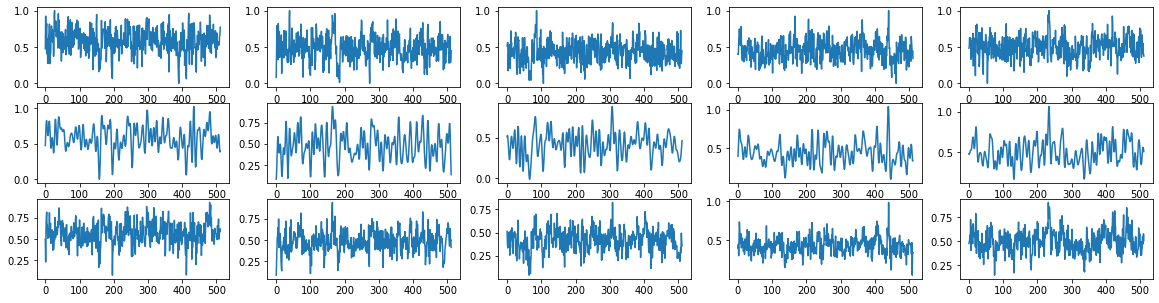

In [122]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 5, figsize=(20,5))
for i in range(5):
    axs[0, i].plot(SR_HR_original_data[i][0][0][:])
    axs[1, i].plot(SR_HR_conditonal_data[i][0][0][:])
    axs[2, i].plot(SR_HR_synthetic_data[i][0][:])
plt.savefig('./SR_LR_simulated.pdf', format="pdf")

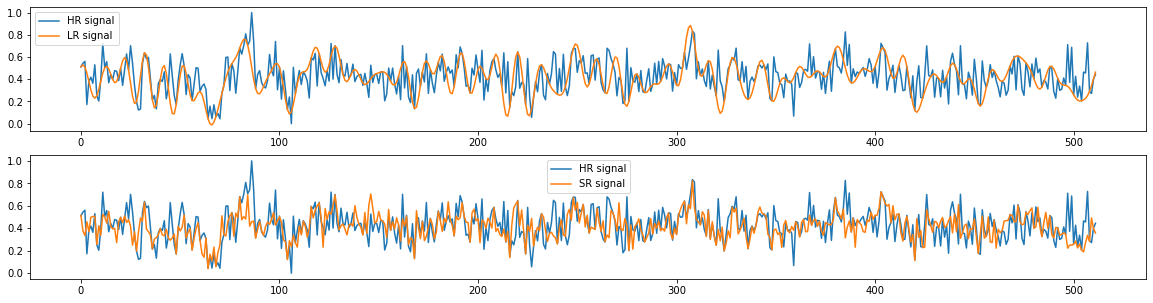

In [130]:
fig, axs = plt.subplots(2, 1, figsize=(20,5))
axs[0].plot(SR_HR_original_data[2][0][0][:], label="HR signal")
axs[0].plot(SR_HR_conditonal_data[2][0][0][:], label = "LR signal")
axs[1].plot(SR_HR_original_data[2][0][0][:], label="HR signal")
axs[1].plot(SR_HR_synthetic_data[2][0][:], label="SR signal")
axs[0].legend()
axs[1].legend()
plt.savefig('./HR_LR_SR_simulated.pdf', format="pdf")